In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ppfft.ppfft import ppfft
from ppfft.inverse.fast_onion_peeling import fast_onion_peeling, precompute_onion_peeling
from ppfft.tools.pad import pad
from ppfft.tools.new_fft import new_fft2

In [2]:
def create_shepp_logan_2(n):
    x, y = np.linspace(-1, 1, n), np.linspace(-1, 1, n)
    xx, yy = np.meshgrid(x, y)
    res = np.zeros_like(xx)

    A_list = [1, -0.8, -0.2, -0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
    a_list = [0.69, 0.6624, 0.11, 0.16, 0.21, 0.046, 0.046, 0.046, 0.023, 0.023]
    b_list = [0.92, 0.874, 0.31, 0.41, 0.25, 0.046, 0.046, 0.023, 0.023, 0.046]
    phi_list = [0, 0, -18 * np.pi / 180, 18 * np.pi / 180, 0, 0, 0, 0, 0, 0]
    x0_list = [0, 0, 0.22, -0.22, 0, 0, 0, -0.08, 0, 0.06]
    y0_list = [0, -0.0184, 0, 0, 0.35, 0.1, -0.1, -0.605, -0.605, -0.605]

    for A, a, b, phi, x0, y0 in zip(A_list, a_list, b_list, phi_list, x0_list, y0_list):
        rot_x = xx * np.cos(phi) + yy * np.sin(phi)
        rot_y = - np.sin(phi) * xx + yy * np.cos(phi)
        mask = (rot_x - x0)**2 / a**2 + (rot_y - y0)**2 / b**2 <= 1
        res[mask] += A

    return res[::-1]

In [3]:
def compute_true_Id(im):
    n = len(im)
    m = 2 * n + 1
    pad_im = pad(im, (m, m))
    return new_fft2(pad_im)[::2, ::2]

In [4]:
n = 1000
im = create_shepp_logan_2(n)

In [5]:
toeplitz_list, nufft_list = precompute_onion_peeling(n)

In [6]:
true_Id = compute_true_Id(im)

In [7]:
hori, vert = ppfft(im)

In [8]:
fast_Id = fast_onion_peeling(hori, vert, toeplitz_list, nufft_list)

In [9]:
%timeit fast_onion_peeling(hori, vert, toeplitz_list, nufft_list)

4.07 s ± 77.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/tmp/ipykernel_1431692/2058087839.py:11: RuntimeWarning: divide by zero encountered in log10
  a = axes[2].imshow(np.log10(np.abs(fast_Id - true_Id)) - np.log10(np.abs(true_Id)))


[None, None, None]

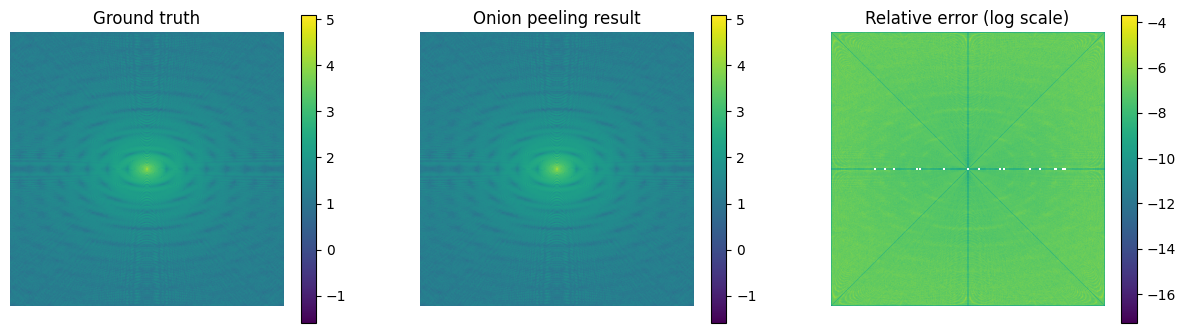

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

a = axes[0].imshow(np.log10(np.abs(true_Id)))
axes[0].set_title(r"Ground truth")
plt.colorbar(a, ax=axes[0])

a = axes[1].imshow(np.log10(np.abs(fast_Id)))
axes[1].set_title("Onion peeling result")
plt.colorbar(a, ax=axes[1])

a = axes[2].imshow(np.log10(np.abs(fast_Id - true_Id)) - np.log10(np.abs(true_Id)))
axes[2].set_title("Relative error (log scale)")
plt.colorbar(a, ax=axes[2])

[ax.set_axis_off() for ax in axes]

In [11]:
from ppfft.inverse.fast_direct_inverse import fast_direct_inversion, precompute_all

In [12]:
precomputations = precompute_all(n)

In [13]:
sol = fast_direct_inversion(hori, vert, precomputations)

In [14]:
%timeit fast_direct_inversion(hori, vert, precomputations)

7.73 s ± 160 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


[None, None, None]

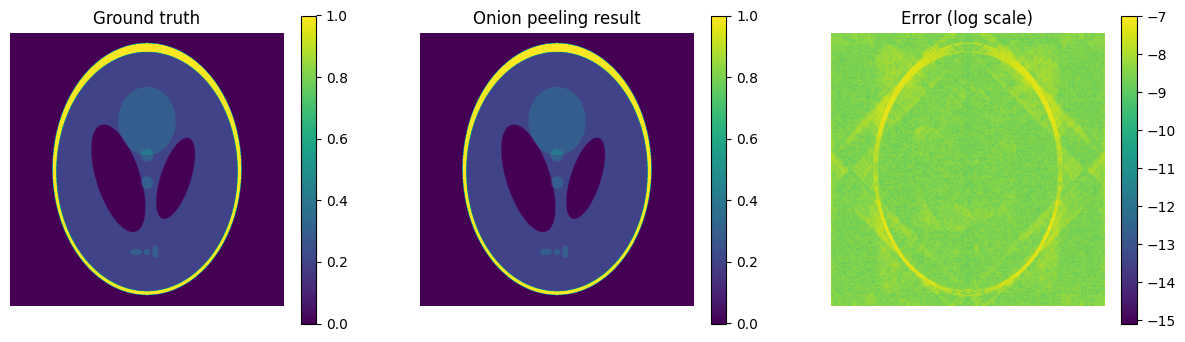

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

a = axes[0].imshow(im)
axes[0].set_title(r"Ground truth")
plt.colorbar(a, ax=axes[0])

a = axes[1].imshow(sol.real)
axes[1].set_title("Onion peeling result")
plt.colorbar(a, ax=axes[1])

a = axes[2].imshow(np.log10(np.abs(im - sol.real)))
axes[2].set_title("Error (log scale)")
plt.colorbar(a, ax=axes[2])

[ax.set_axis_off() for ax in axes]

In [1]:
from silx.image.projection import Projection
from ppfft.reconstruction.fast_reconstruction import fast_reconstruction

ImportError: Please install pyopencl in order to use opencl backprojection

In [17]:
m = 2 * n + 1
theta = np.linspace(-np.pi/2, np.pi/2, endpoint=False, num=n) # with n projections this time
proj = Projection(im.shape, angles=theta)
sinogram = proj.projection(im)

In [18]:
sol = fast_reconstruction(sinogram, precomputations, angles=theta, tol=None)

In [19]:
%timeit fast_reconstruction(sinogram, precomputations, angles=theta, tol=None)

10 s ± 55.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


[None, None, None, None]

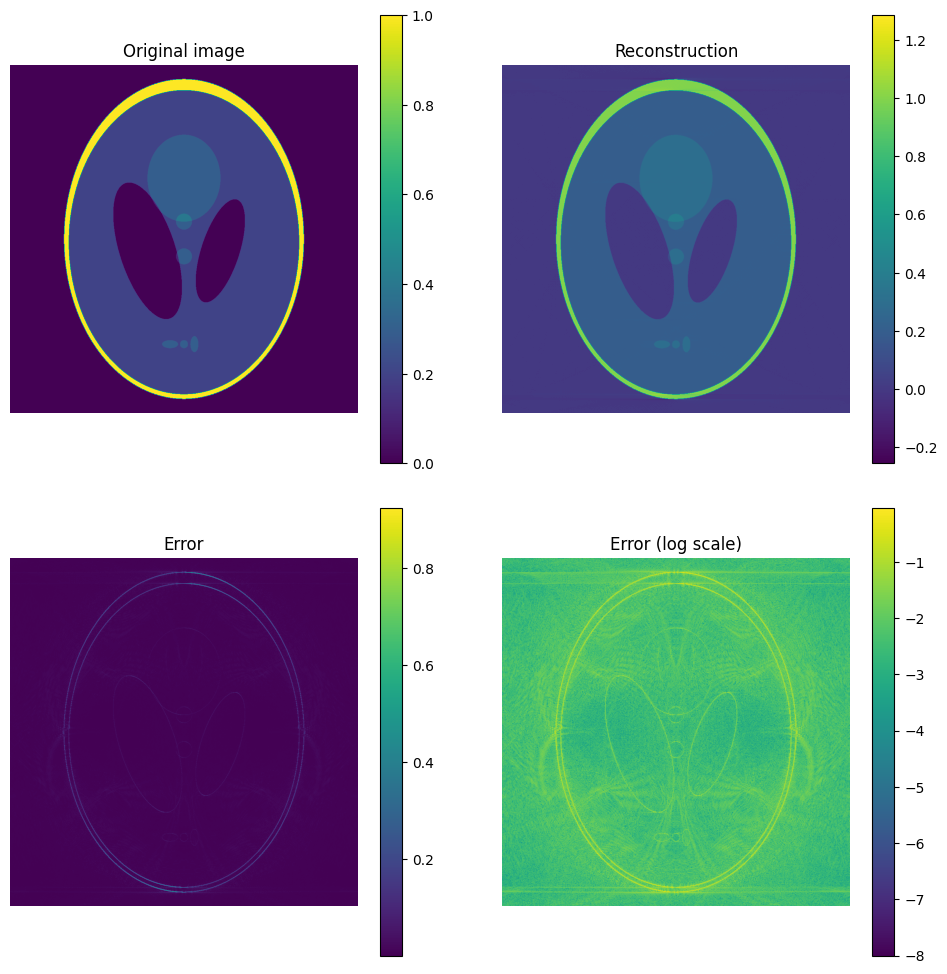

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

plt.tight_layout()

a = axes[0, 0].imshow(im)
plt.colorbar(a, ax=axes[0, 0])
axes[0, 0].set_title(f"Original image")

a = axes[0, 1].imshow(sol.real)
plt.colorbar(a, ax=axes[0, 1])
axes[0, 1].set_title(f"Reconstruction")

a = axes[1, 0].imshow(np.abs(sol.real - im))
plt.colorbar(a, ax=axes[1, 0])
axes[1, 0].set_title("Error")

a = axes[1, 1].imshow(np.log10(np.abs(sol.real - im)))
plt.colorbar(a, ax=axes[1, 1])
axes[1, 1].set_title("Error (log scale)")

[ax.set_axis_off() for ax in axes.ravel()]

In [21]:
from silx.opencl.backprojection import Backprojection
B = Backprojection(sinogram.shape)
recon = B.filtered_backprojection(sinogram)

The gpyfft module was not found. The Fourier transforms will be done on CPU. For more performances, it is advised to install gpyfft.


In [33]:
%timeit B.filtered_backprojection(sinogram)

2.89 s ± 185 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


[None, None, None, None]

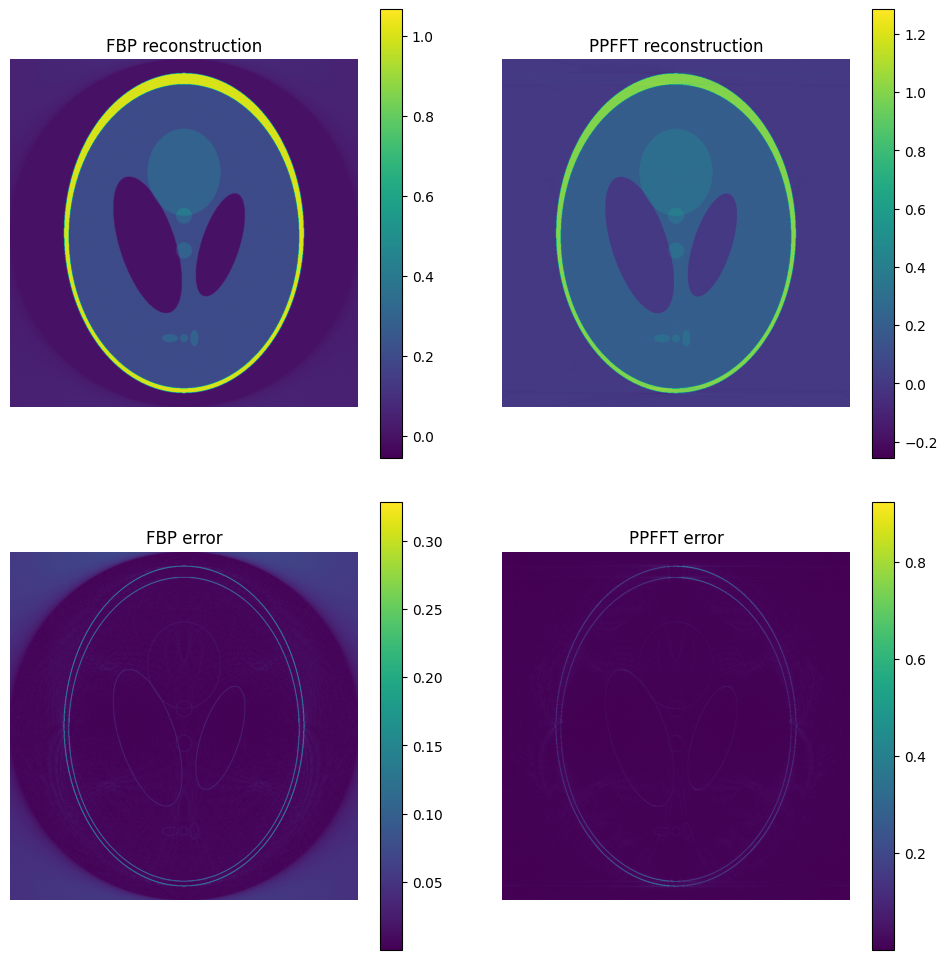

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

plt.tight_layout()

a = axes[0, 0].imshow(recon.T[:, ::-1])
plt.colorbar(a, ax=axes[0, 0])
axes[0, 0].set_title(f"FBP reconstruction")

a = axes[0, 1].imshow(sol.real)
plt.colorbar(a, ax=axes[0, 1])
axes[0, 1].set_title(f"PPFFT reconstruction")

a = axes[1, 0].imshow(np.abs(recon.T[:, ::-1] - im))
plt.colorbar(a, ax=axes[1, 0])
axes[1, 0].set_title("FBP error")

a = axes[1, 1].imshow(np.abs(sol.real - im))
plt.colorbar(a, ax=axes[1, 1])
axes[1, 1].set_title("PPFFT error")

[ax.set_axis_off() for ax in axes.ravel()]

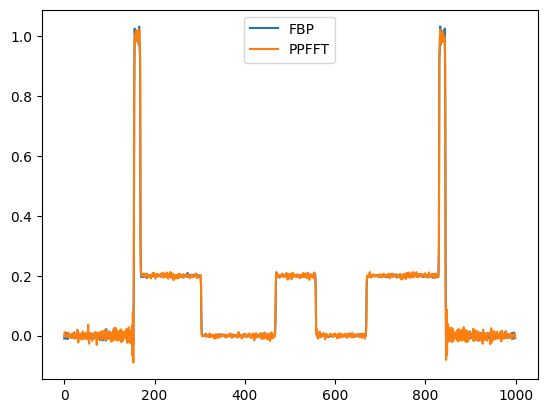

In [32]:
plt.plot(recon.T[:, ::-1][n//2], label='FBP')
plt.plot(sol.real[n//2], label='PPFFT')
plt.legend()

# Time complexity

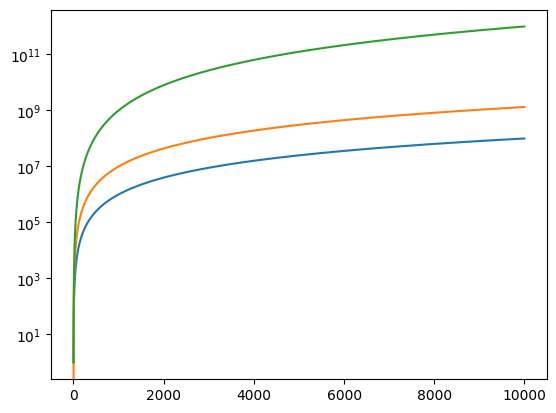

In [53]:
n = np.arange(1, 1e4)

plt.plot(n**2)
plt.plot(n**2 * np.log2(n))
plt.plot(n**3)

plt.yscale("log")